In [1]:
!pip install keras.tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [28]:
import numpy as np
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [7]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MedHouseVal'] = data.target

In [8]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [9]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [10]:
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


In [11]:
X = df.drop(['MedHouseVal'], axis=1)
y = df['MedHouseVal']

In [12]:
X.shape

(20640, 8)

In [13]:
y.shape

(20640,)

In [14]:
X_train,X_test,y_train,y_test =  train_test_split(X,y,random_state=42)

In [17]:
X_train.shape,X_test.shape

((15480, 8), (5160, 8))

In [20]:
y_train.shape,y_test.shape

((15480,), (5160,))

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_callbacks():
    callbacks = []

    # Early stopping to stop training when a monitored metric has stopped improving
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,  # Number of epochs to wait for improvement
        restore_best_weights=True)
    callbacks.append(early_stopping)

    # Model checkpoint to save the best model during training
    model_checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True)
    callbacks.append(model_checkpoint)

    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,  # Factor by which the learning rate will be reduced
        patience=5)  # Number of epochs with no improvement after which learning rate will be reduced
    callbacks.append(reduce_lr)

    return callbacks


In [35]:
def build_model(hp):
  model = Sequential()
  # Tune the number of layers and units in each layer
  for i in range(hp.Int('num_layers',1,4)):
    model.add(Dense(units=hp.Int('units_'+str(i),min_value=32,max_value=512,step=32),activation='relu'))
    # Output layer
    model.add(Dense(1,activation='linear'))
  model.compile(optimizer=Adam(hp.Choice('learning_rate',values=[1e-4, 1e-3, 1e-2])),loss='mean_squared_error')
  return model


In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_loss',
    max_trials = 10,
    executions_per_trial = 2,
    directory = 'project_california_housing ',
    project_name = 'california_housing'
)

In [42]:
callback = create_callbacks()

In [43]:
tuner.search(
    X_train,
    y_train,
    epochs = 5,
    validation_split=0.2,
    batch_size =32,
    callbacks = callback
)

Trial 10 Complete [00h 00m 24s]
val_loss: 0.46856464445590973

Best val_loss So Far: 0.3669261038303375
Total elapsed time: 00h 03m 37s


Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0545 - val_loss: 0.6131 - learning_rate: 0.0100
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4925 - val_loss: 0.4374 - learning_rate: 0.0100
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3923 - val_loss: 0.3909 - learning_rate: 0.0100
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3589 - val_loss: 0.3842 - learning_rate: 0.0100
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3550 - val_loss: 0.3727 - learning_rate: 0.0100
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3407 - val_loss: 0.3657 - learning_rate: 0.0100
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4590 - val_loss: 0.3769 - learning_rate: 0.0100
Epoch 8/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3592 - val_loss: 0.3959 - learning_rate: 0.0100
Epoch 9/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3287 - val_loss: 0.3616 - learning_rate: 0.0100
E

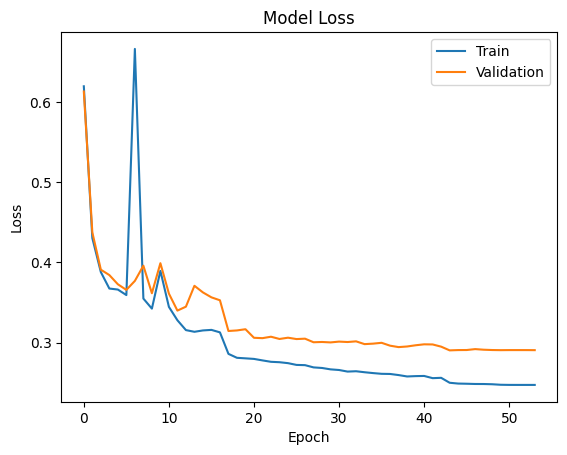

In [45]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train,
                         validation_split=0.2,
                         epochs=100,
                         batch_size=32,
                         callbacks=callback)  # Include callbacks in the training

# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the best model: {mse:.2f}")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
